In [3]:
from pandas import Series

# Corrected function for train-test split (ensures input is a Series)
def series_train_test_split(data: Series, trn_pct: float = 0.90) -> tuple[Series, Series]:
    if not isinstance(data, Series):
        raise ValueError("Input data must be a pandas Series.")
    trn_size: int = int(len(data) * trn_pct)
    train: Series = data.iloc[:trn_size]  # One-dimensional indexing
    test: Series = data.iloc[trn_size:]
    return train, test


In [4]:
from pandas import read_csv, DataFrame, Series

# File details
filename: str = "/Users/dominikfrank/Library/Mobile Documents/com~apple~CloudDocs/Desktop/University/Master/Semester 1/PII/Data Science/Code for Project/DataScience/forecast_gdp_europe.csv"
file_tag: str = "GDP_Europe"
target: str = "GDP"
timecol: str = "Year"

# Load the dataset
data: DataFrame = read_csv(
    filename,
    sep=",",  # Semicolon-separated values
    decimal=".",  # Use period for decimal
    parse_dates=[timecol],  # Parse the Date column
    infer_datetime_format=True,
)
data.set_index(timecol, inplace=True)

# Extract the target series
series: Series = data[target]

# Check if the series is properly extracted
if not isinstance(series, Series):
    raise ValueError(f"Expected a Series, but got {type(series)}")


/var/folders/r8/55mn588571z9y3flsnt4y5q00000gn/T/ipykernel_27312/52668298.py:10: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data: DataFrame = read_csv(


In [5]:
# Perform train-test split
train, test = series_train_test_split(series, trn_pct=0.90)

# Check train and test sizes
print(f"Train size: {len(train)}, Test size: {len(test)}")


Train size: 52, Test size: 6


In [6]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_line_chart

def exponential_smoothing_study(train: Series, test: Series, measure: str = "R2"):
    """
    Perform an Exponential Smoothing study to find the best alpha value.
    Parameters:
        train (Series): Training dataset.
        test (Series): Test dataset.
        measure (str): Metric for evaluation (e.g., "R2" or "MAPE").
    Returns:
        best_model: Fitted model with the best alpha.
        best_params: Dictionary of the best parameters.
    """
    alpha_values = [i / 10 for i in range(1, 10)]  # Alpha values from 0.1 to 0.9
    flag = measure in ["R2", "MAPE"]
    best_model = None
    best_params: dict = {"name": "Exponential Smoothing", "metric": measure, "params": ()}
    best_performance: float = float("-inf")  # Initialize best performance with a very low value

    yvalues = []
    for alpha in alpha_values:
        # Fit the Simple Exponential Smoothing model
        tool = SimpleExpSmoothing(train)
        model = tool.fit(smoothing_level=alpha, optimized=False)
        prd_tst = model.forecast(steps=len(test))  # Forecast for the test set

        # Evaluate the model using the chosen metric
        eval: float = FORECAST_MEASURES[measure](test, prd_tst)
        if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
            best_performance = eval
            best_params["params"] = (alpha,)
            best_model = model
        yvalues.append(eval)

    # Output the best results and plot the performance
    print(f"Exponential Smoothing best with alpha={best_params['params'][0]:.1f} -> {measure}={best_performance}")
    plot_line_chart(
        alpha_values,
        yvalues,
        title=f"Exponential Smoothing ({measure})",
        xlabel="Alpha",
        ylabel=measure,
        percentage=flag,
    )

    return best_model, best_params


Exponential Smoothing best with alpha=0.4 -> R2=-0.038441769275370685


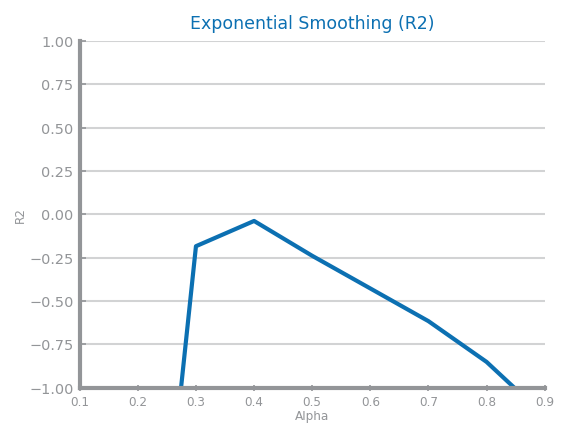

In [8]:
from matplotlib.pyplot import savefig

# Run the exponential smoothing study
measure = "R2"  # Change to another measure like "MAE" or "RMSE" if needed
best_model, best_params = exponential_smoothing_study(train, test, measure=measure)

# Save the performance study plot
#savefig(f"images/{file_tag}_exponential_smoothing_{measure}_study.png")


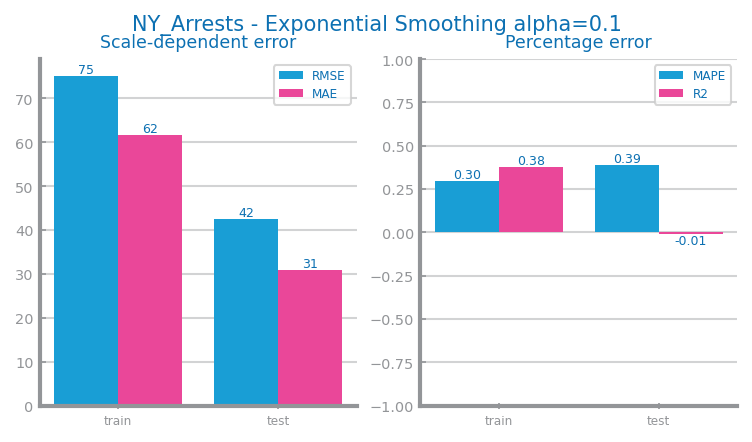

In [10]:
from dslabs_functions import plot_forecasting_eval

# Get the best smoothing parameter
params = best_params["params"]

# Generate predictions
prd_trn = best_model.predict(start=0, end=len(train) - 1)  # Train predictions
prd_tst = best_model.forecast(steps=len(test))  # Test predictions

# Evaluate the model
plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Exponential Smoothing alpha={params[0]}")
savefig(f"images/{file_tag}_exponential_smoothing_{measure}_eval.png")


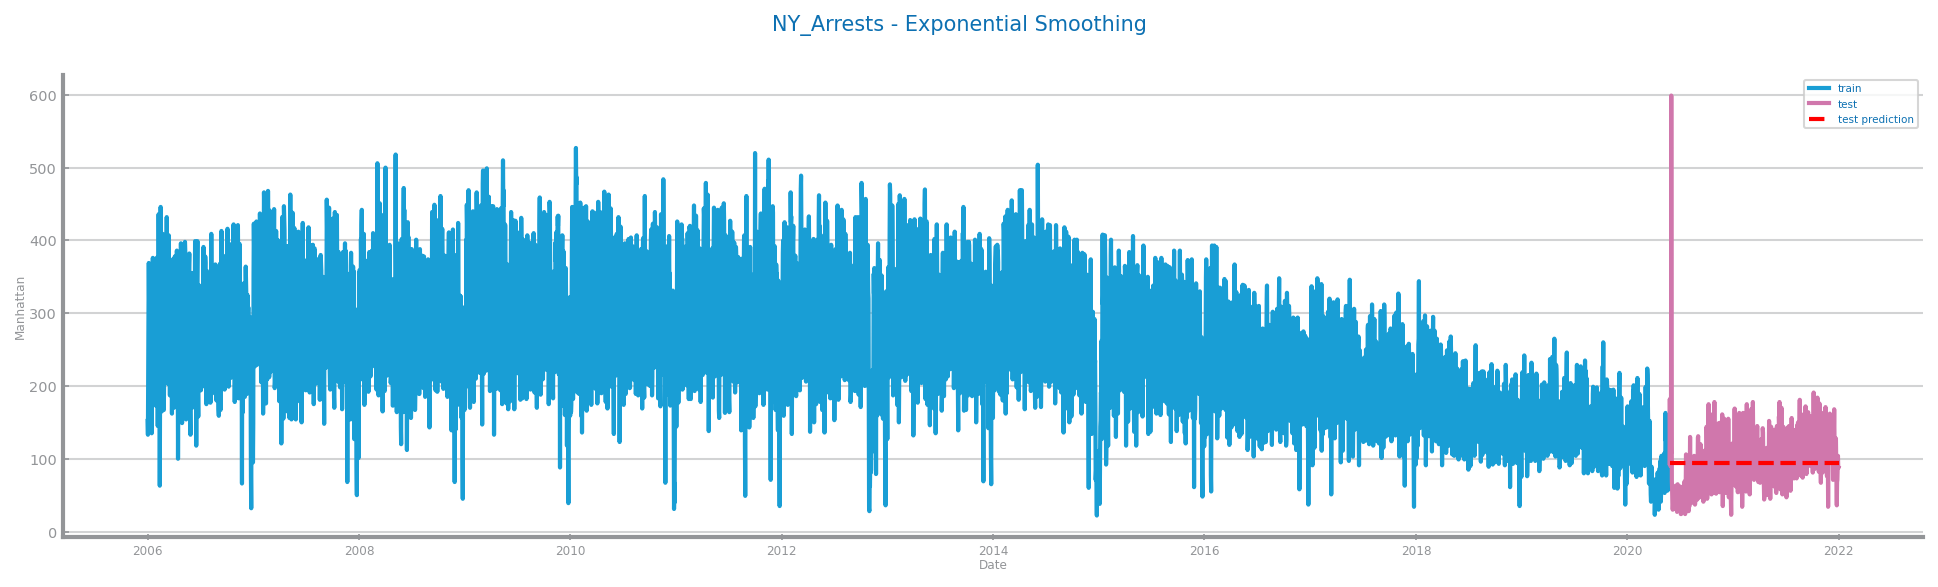

In [11]:
from dslabs_functions import plot_forecasting_series

# Visualize the train, test, and predictions
plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Exponential Smoothing ",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"images/{file_tag}_exponential_smoothing_{measure}_forecast.png")
